In [ ]:
from zipfile import ZipFile
import os
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)

root_path = os.path.dirname(os.path.abspath(__file__))

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!cd FacesGANTorch/data
!kaggle datasets download -d jessicali9530/celeba-dataset
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
    zipObj.extractall()
!cd FacesGANTorch/scripts

In [ ]:
root_data = root_path + 'data/img_align_celeba/'
workers = 2
batch_size = 128
image_size = 128
nz = 100
ngf = 64
ndf = 32
num_epochs = 5
lr = 0.0002
beta1 = 0.5

In [ ]:
dataset = dset.ImageFolder(root_data,transform=transforms.Compose([
                                                              transforms.Resize(image_size),
                                                              transforms.CenterCrop(image_size),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.normal_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*16, ngf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf * 4, ngf*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
        nn.Tanh()
    )
  def forward(self, x):
      return self.main(x)

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 16),
        nn.LeakyReLU(0.2, True),

        nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.main(x)

netD = Discriminator().to(device)
netD.apply(weights_init)

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label, fake_label = 1, 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Starting training loop>>>')

for epoch in range(num_epochs):
  for i, (x, y) in enumerate(dataloader):
    netD.zero_grad()
    real_cpu = x.to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output = netD(real_cpu).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)
    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake
    optimizerD.step()


    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters+=1

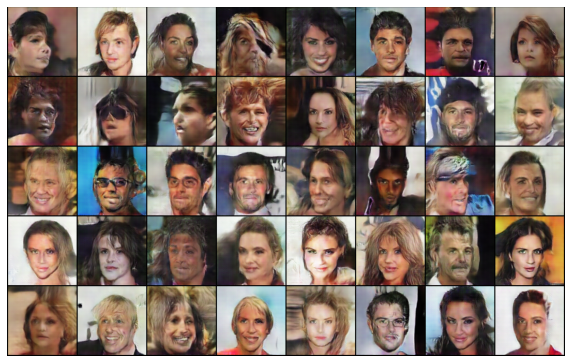

In [ ]:
noise = torch.randn(40, nz, 1, 1, device=device)
img = netG(noise).detach().cpu()
some = img_list[-1].permute(1,2,0)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(vutils.make_grid(img, padding=2, normalize=True).permute(1,2,0))